<a href="https://colab.research.google.com/github/itzahs/SSL-for-RS/blob/main/4_2_ModelInference_Embeddings_SSL4RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 **Semi-Supervised Learning for Remote Sensing (SSL4RS) Workshop** 🛰️

## 📂 Section 1 - Get Data & Software: Dataset Download & Augmentation
## 🛠️ Section 2 - Train Model: Implementing FixMatch Algorithm with PyTorch
## 📊 Section 3 - Model Evaluation: Analyzing Accuracy & Computational Cost from Log Files
## 📈 Section 4 - Model Inference: Classification Accuracy and Embeddings Visualization

### 📚 Setting Up the Working Folder & Importing Required Packages


In [ ]:
from google.colab import drive

# Mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard Library Imports
import os
import sys
import requests
import zipfile

# Third-Party Imports
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from torchvision.transforms.functional import to_pil_image

In [ ]:
#  Monitor the GPU usage
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
## Install the required libraries
%%capture
!pip install mmcv-lite # the version used to be mmcv-full and now it's mmcv-lite
!pip install torch torchvision torchaudio
!pip install apex
!pip install tensorboardX
!pip install tensorboard
!pip install tensorrt
!pip install tqdm

### 📂 Downloading and Uploading Experiment Files

To initiate the experiment, we'll download the files

1. Download Experiment Files that are hosted in this link: [Experiment Files](https://drive.google.com/file/d/1oqXxwgOpMVwYahNcjfUxUJ9YNc1i94RX/view?usp=share_link).

2. Upload the files to the designated directory in your Google Drive:
     `/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results`

Your directory structure should now resemble the following:

| Classification-SemiCLS                 |
|----------------------------------------|
| results                                |
| ├ comatch_4_UCM_RN18              |
|     └─── comatch_4_UCM_RN18.log  |
|     └─── comatch_4_UCM_RN18.tar  |
|     └─── comatch_4_UCM_RN18.py   |

- The `.py` file represents the configuration file.
- The `.log` file contains the training output.
- The `.tar` file contains the trained model.

By following these steps, you'll have the necessary files in place to proceed with the model evaluation.



In [ ]:
# Set working folder as default
%cd "/content/drive/MyDrive/SSL4RS/Classification-SemiCLS"

# Append the parent directory (Classification-SemiCLS) to sys.path:
# The list in Python that specifies the directories for modules and packages to import.
sys.path.append('/content/drive/MyDrive/SSL4RS/Classification-SemiCLS')

# Path to the model checkpoint and configuration
selected_model = 'comatch_4_UCM_RN18'
model_folder = f'/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results/{selected_model}'
model_best_path = model_folder+f'/{selected_model}.tar'       #checkpoint to the best model from all the epochs trained
config_path = model_folder+f'/{selected_model}.py'                #configuration file used to train the model

/content/drive/MyDrive/SSL4RS/Classification-SemiCLS


# Evaluating the model using confusion matrix, precision and recall

### Read configuration file and best model checkpoint

In [ ]:
from mmengine.config import Config

# Read the configuration file
cfg = Config.fromfile(config_path)

# Extract the input size from the vpipeline section
input_size = cfg.data.vpipeline[1]['size']

# Print a summary of the configuration
#print(cfg.pretty_text) #for prettier version
cfg

Config (path: /content/drive/MyDrive/SSL4RS/Classification-SemiCLS/results/comatch_4_UCM_RN18/comatch_4_UCM_RN18.py): {'train': {'eval_step': 1024, 'total_steps': 524288, 'trainer': {'type': 'CoMatch', 'threshold': 0.95, 'queue_batch': 5, 'contrast_threshold': 0.8, 'da_len': 32, 'T': 0.2, 'alpha': 0.9, 'lambda_u': 1.0, 'lambda_c': 1.0, 'loss_x': {'type': 'cross_entropy', 'reduction': 'mean'}}}, 'num_classes': 21, 'model': {'type': 'resnet18', 'width': 1, 'in_channel': 3, 'num_class': 21, 'proj': True, 'low_dim': 64}, 'ucm_mean': [0.485, 0.456, 0.406], 'ucm_std': [0.229, 0.224, 0.225], 'data': {'type': 'MyDataset', 'num_workers': 4, 'num_labeled': 84, 'num_classes': 21, 'batch_size': 32, 'expand_labels': False, 'mu': 7, 'root': '/scratch/isequeir/ssl/data/UCM/Images', 'labeled_names_file': '/scratch/isequeir/ssl/data/UCM/Images/UCM_train.txt', 'test_names_file': '/scratch/isequeir/ssl/data/UCM/Images/UCM_test.txt', 'lpipelines': [[{'type': 'Resize', 'size': 64}, {'type': 'RandomHorizont

In [ ]:
from models import builder as model_builder

# Load the model state dictionary from the checkpoint of the best model
best_model = torch.load(model_best_path, map_location=torch.device('cpu'))

# Print all keys in the checkpoint of the best model
print(best_model.keys())

# Print some information of the model
print("Best model was obtained on the epoch:", best_model['epoch'])
print("The best top-1 accuracy corresponds to:", best_model['best_acc'])

# You can also loop through all the keys and print their values
#for key, value in best_model.items():
#    print(f"Key: {key}, Value: {value}")

dict_keys(['epoch', 'state_dict', 'ema_state_dict', 'acc', 'best_acc', 'optimizer', 'scheduler', 'queue_feats', 'queue_probs', 'queue_ptr'])
Best model was obtained on the epoch: 143
The best top-1 accuracy corresponds to: 94.38095225016276


### Load best model

In [ ]:
# Create the model architecture from the configuration file
model = model_builder.build(cfg.model)

# Load the model state dictionary from the checkpoint
model.load_state_dict(best_model['state_dict'])

# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=(3, input_size, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           9,408
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          36,864
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
             ReLU-10           [-1, 64, 15, 15]               0
       BasicBlock-11           [-1, 64, 15, 15]               0
           Conv2d-12           [-1, 64, 15, 15]          36,864
      BatchNorm2d-13           [-1, 64, 15, 15]             128
             ReLU-14           [-1, 64,

### Prepare testing dataset

In [ ]:
from dataset.transforms.builder import BaseTransform
from dataset.MyDataset import MyDataset
from torch.utils.data import DataLoader, SequentialSampler

# Load the validation transformations from the configuration file
transform_val = BaseTransform(cfg.data.vpipeline)
# Print the pipeline attribute
print(transform_val.pipeline)

# Adapt paths to data
cfg.data.root = './data/UCM/Images'
cfg.data.test_names_file = './data/UCM/Images/UCM_test.txt'

# make dataset (dataset_builder.build)
test_dataset = MyDataset(names_file=cfg.data.test_names_file, transform=transform_val)

# make dataset loader (train_semi.get_dataloader)
test_loader = DataLoader(test_dataset,
                          sampler=SequentialSampler(test_dataset), #SequentialSampler for testing and RandomSampler for training
                          batch_size=cfg.data.batch_size,
                          #num_workers=cfg.data.num_workers, #ideally import from config file
                          num_workers=2)  # Adjusted value based on colab system)

[{'type': 'Resize', 'size': 64}, {'type': 'CenterCrop', 'size': 60}, {'type': 'ToTensor'}, {'type': 'Normalize', 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}]


In [ ]:
# Create an iterator for the DataLoader
test_loader_iter = iter(test_loader)

# Fetch a batch of data from the iterator
batch_data, batch_labels = next(test_loader_iter)

# Now you can examine the batch_data and batch_labels
# For example, print the shape of the batch_data and batch_labels
print("Batch data shape:", batch_data.shape)
print("Batch labels shape:", batch_labels.shape)
print(batch_labels)

Batch data shape: torch.Size([32, 3, 60, 60])
Batch labels shape: torch.Size([32])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


### Perform inference

In [ ]:
# Important to track the time during inference and save it as reference

import time

start = time.time()

#Code excecution

end = time.time()

print(f"generating projections with T-SNE took: {(end-start):.2f} sec")

generating projections with T-SNE took: 0.00 sec


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, cohen_kappa_score

# Set the model to evaluation mode
model.eval()

all_predictions = []
all_labels = []
all_embeddings = []  # CoMatch only

# Perform inference and calculate metrics
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass to get and store the embeddings
        _, embeddings = model(inputs)  # CoMatch only
        all_embeddings.extend(embeddings.cpu().numpy())

        # Forward pass
        # Class probabilities for each sample in the batch
        outputs_tuple = model(inputs) # [batch_size, num_classes] torch.Size([8, 21])

        # Get highest prediction per sample and assign label
        max_values, predicted = torch.max(outputs_tuple[0], dim=1)
        #argmax_dim1, predicted = torch.max(outputs_tuple, 1) # tensor([18.2504, 17.0848, 16.0119, 13.5324, 23.9052, 18.9193, 16.4092, 15.3505]) tensor([0, 0, 0, 0, 0, 0, 0, 0])

        #convert predicted tensor containing class labels for each input sample into an array
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Calculate precision and recall
precision = precision_score(all_labels, all_predictions, average=None)
recall = recall_score(all_labels, all_predictions, average=None)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(all_labels, all_predictions)

# Print or use the calculated metrics as needed
print("Confusion Matrix:")
print(conf_matrix)
print("\nPrecision:", precision)
print("\nRecall:", recall)
print("\nCohen's Kappa:", kappa)


Confusion Matrix:
[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 47  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  1]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0 43  0  0  0  0  0  1  2  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 49  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 46  0  0  2  1  0  0  0  0  0]
 [ 0  0  0  0  2  0  2  0  0  0  1  0 45  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 49  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 50  0  0  0  0

In [ ]:
# Get the names of the classes
# Get subfolders path
folders = sorted([f.path for f in os.scandir(cfg.data.root) if f.is_dir()])

# Create dictionary where keys are the string of the class and value the integer
classes_dict = {}
for i, folder in enumerate(folders):
    folder_name = os.path.basename(folder)
    classes_dict[folder_name] = i

# Create a reverse dictionary to map integer labels back to class names
label_to_class = {v: k for k, v in classes_dict.items()}

# Replace numeric labels with class names for all_labels and all_predictions
all_labels_names = [label_to_class[label] for label in all_labels]
all_predictions_names = [label_to_class[label] for label in all_predictions]

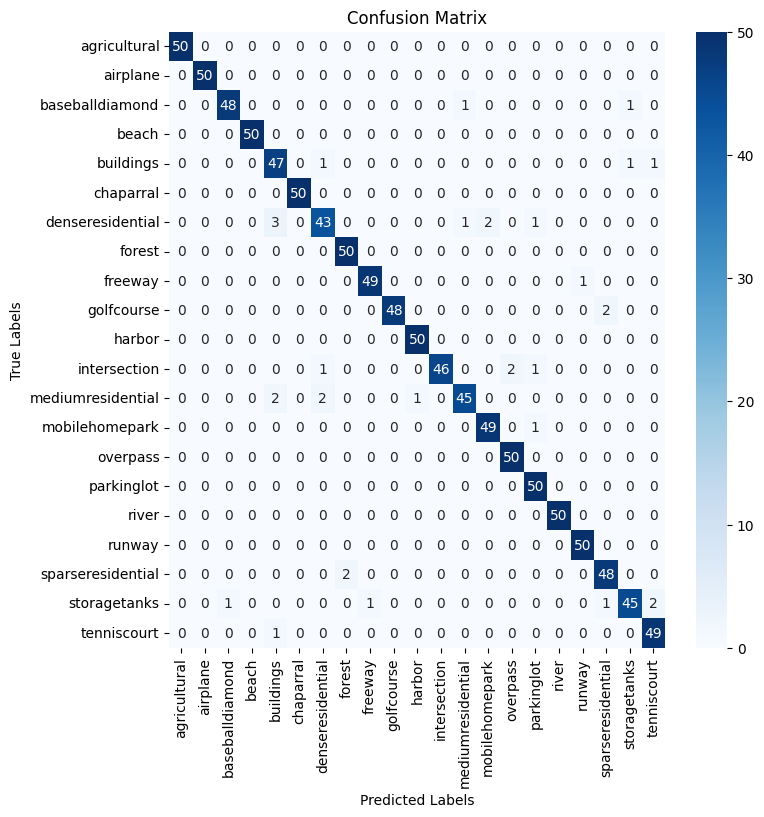

Precision:
[1.         1.         0.97959184 1.         0.88679245 1.
 0.91489362 0.96153846 0.98       1.         0.98039216 1.
 0.95744681 0.96078431 0.96153846 0.94339623 1.         0.98039216
 0.94117647 0.95744681 0.94230769]

Recall:
[1.   1.   0.96 1.   0.94 1.   0.86 1.   0.98 0.96 1.   0.92 0.9  0.98
 1.   1.   1.   1.   0.96 0.9  0.98]

Cohen's Kappa: 0.967


In [ ]:
# Visualize the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 8))

#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues') # numerical names
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_dict, yticklabels=classes_dict) # string names
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print precision and recall for each class
print("Precision:")
print(precision)
print("\nRecall:")
print(recall)

# Print Cohen's Kappa
print("\nCohen's Kappa:", kappa)

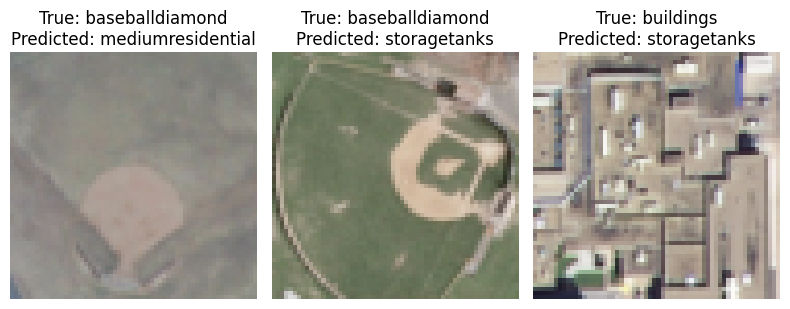

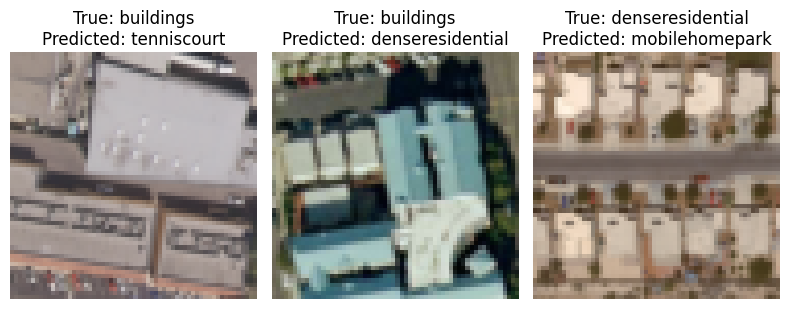

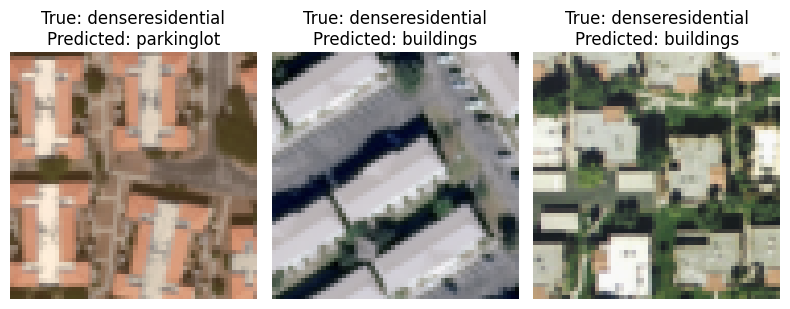

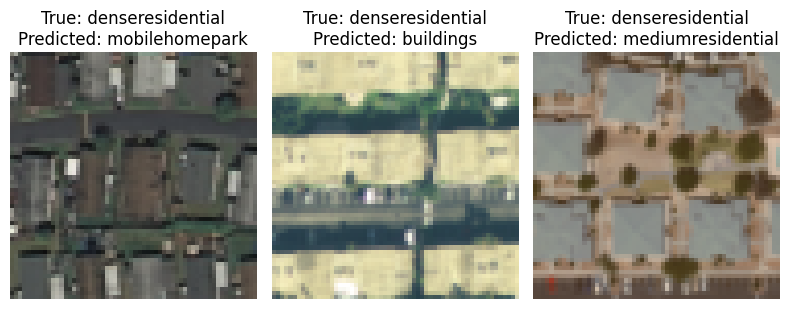

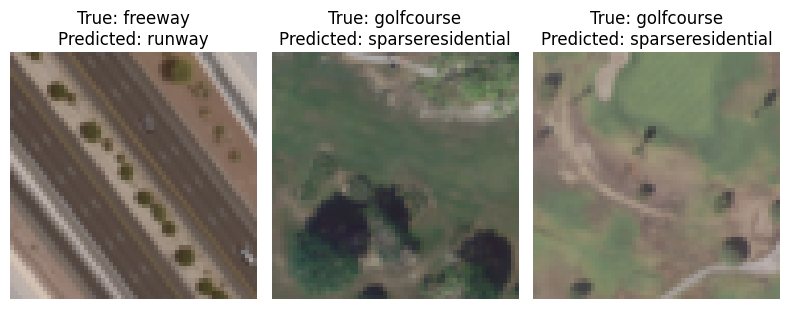

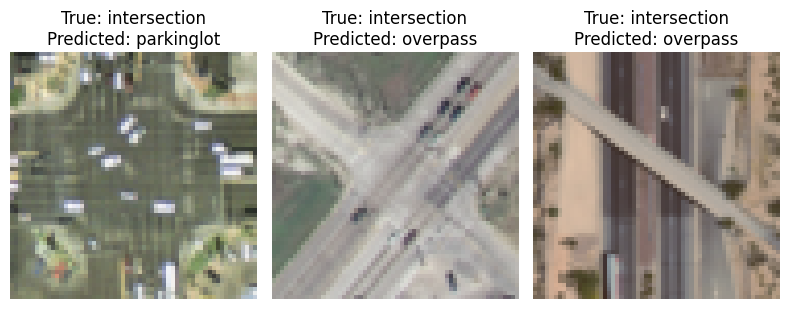

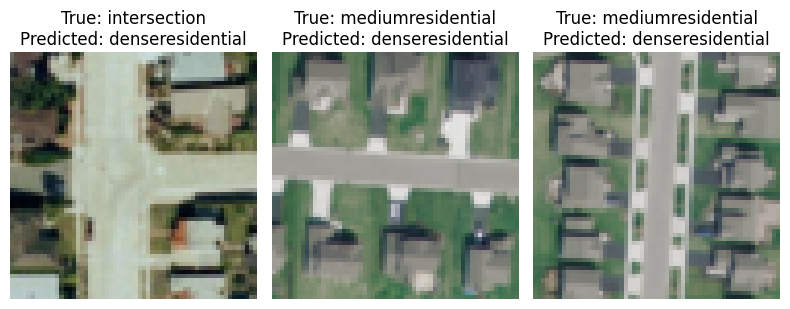

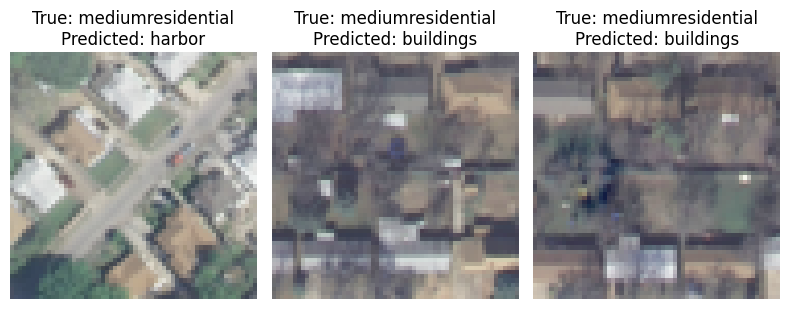

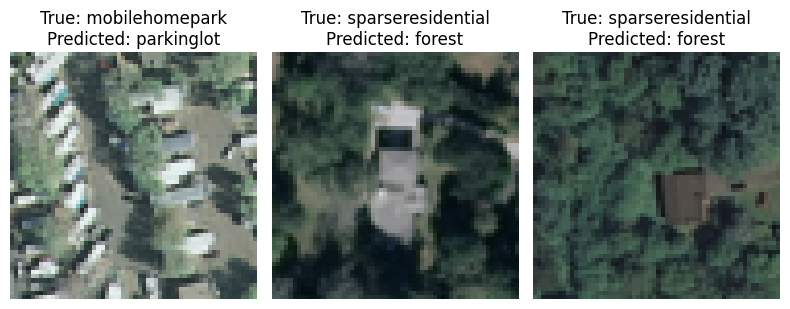

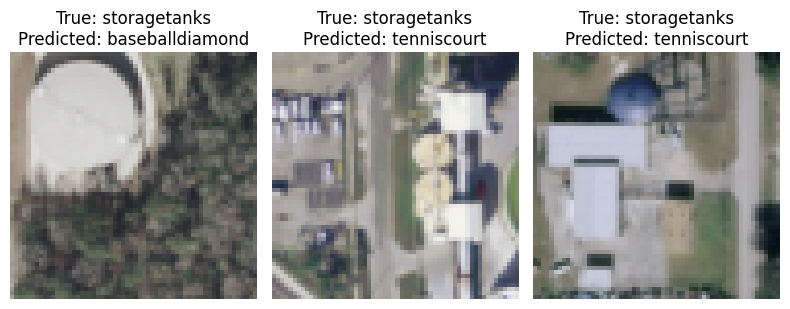

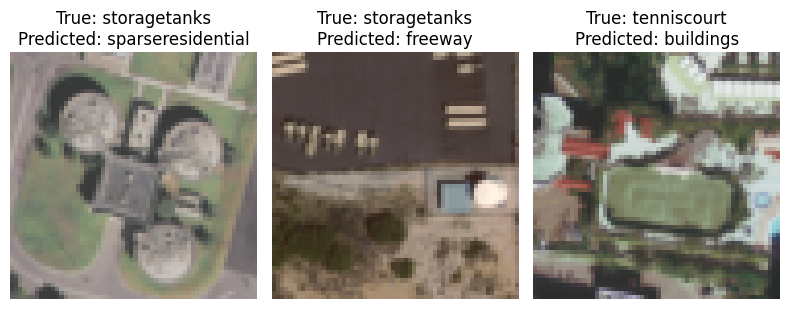

In [ ]:
# Create a directory to save the misclassified images
output_dir = "./results/misclassified_images/UCM"
os.makedirs(output_dir, exist_ok=True)

# Create test dataset without normalization for visualization purposes
transform_val_without_normalize = BaseTransform(cfg.data.vpipeline[:-1])
test_dataset_pil = MyDataset(names_file=cfg.data.test_names_file, transform=transform_val_without_normalize)

# Identify misclassified indices
misclassified_indices = np.where(np.array(all_labels) != np.array(all_predictions))[0]

# Number of images to show per row
images_per_row = 3

# Iterate over misclassified examples
for i in range(0, len(misclassified_indices), images_per_row):
    plt.figure(figsize=(8, 8))  # Adjust the figure size as needed

    for j in range(images_per_row):
        index = i + j
        if index < len(misclassified_indices):
            misclassified_index = misclassified_indices[index]
            input_image, true_label_numeric = test_dataset_pil[misclassified_index]
            true_label = label_to_class[true_label_numeric]
            predicted_label = all_predictions_names[misclassified_index]

            # Convert input_image to PIL Image
            input_image = to_pil_image(input_image.cpu())

            # Display the image with labels
            plt.subplot(1, images_per_row, j + 1)
            plt.imshow(input_image)
            plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save the entire plot as an image
    plot_filename = os.path.join(output_dir, f'misclassified_plot_{i}.png')
    plt.savefig(plot_filename)
    plt.close()  # Close the plot to release memory

# Visualizing model embeddings with t-SNE

In [ ]:
print(f"The number of total samples is: {len(all_embeddings)}")
print(f"The number of dimensions of the extracted embeddings per sample is: {all_embeddings[1].shape}")

The number of total samples is: 1050
The number of dimensions of the extracted embeddings per sample is: (64,)


## 2D t-SNE

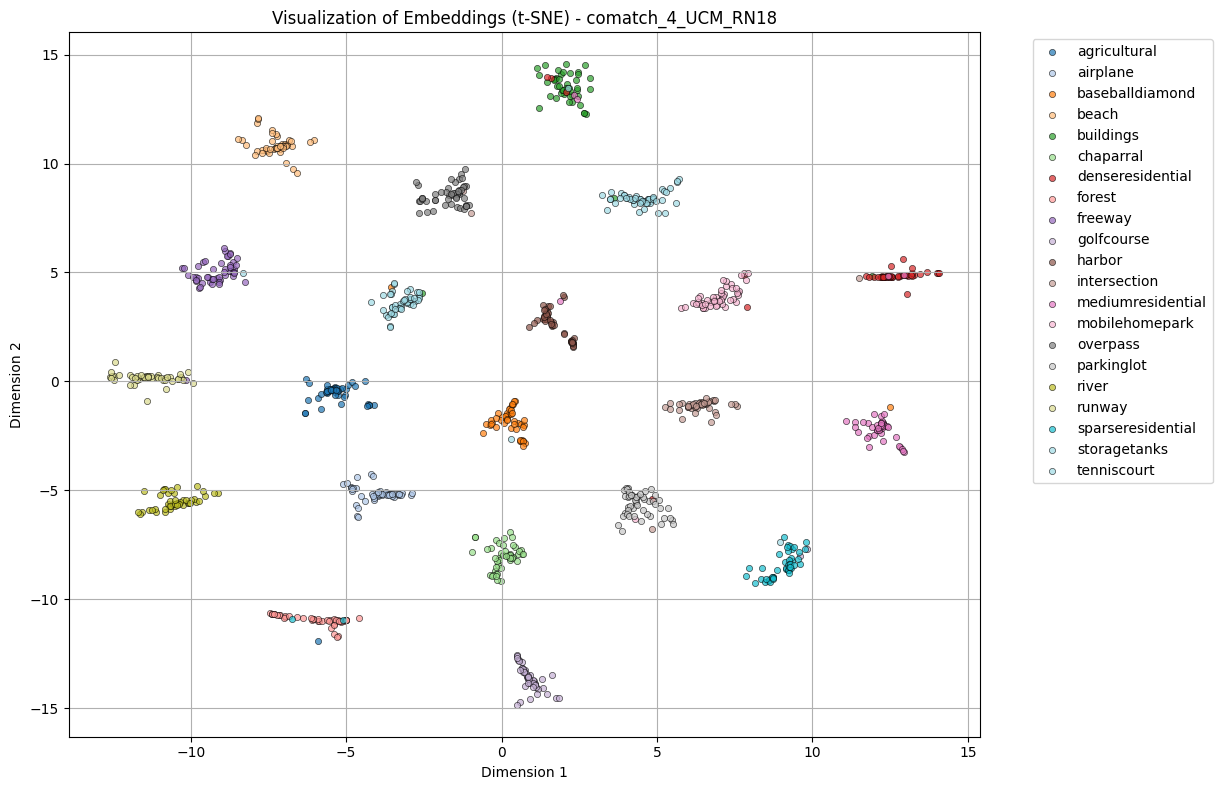

In [ ]:
# TSNE in 2D
from sklearn.manifold import TSNE

# Convert the list of embeddings to a NumPy array
all_embeddings = np.array(all_embeddings)

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create a scatter plot for visualization with enhancements
plt.figure(figsize=(10, 8))  # Increase figure size for clarity
unique_labels = np.unique(all_labels)
class_colors = plt.colormaps['tab20'](np.arange(len(unique_labels)))  # Use a distinct color map

for i, label in enumerate(unique_labels):
    indices = np.where(all_labels == label)
    class_name = label_to_class[label]
    plt.scatter(
        embeddings_2d[indices, 0], embeddings_2d[indices, 1],
        label=class_name, c=[class_colors[i]],
        s=20, alpha=0.7, edgecolors='k', linewidths=0.5  # Adjust point size and transparency
    )

plt.title(f'Visualization of Embeddings (t-SNE) - {selected_model}')
plt.xlabel("Dimension 1")  # Label x-axis
plt.ylabel("Dimension 2")  # Label y-axis
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Ensure all elements fit within the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside the plot
plt.savefig(f'./results/tsne_{selected_model}.png', bbox_inches='tight')

## 3D t-SNE

Source code: [roboflow-ai](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/image_embeddings_analysis_part_1.ipynb#scrollTo=j3EuKYrgrxjU)

In [ ]:
import plotly.graph_objects as go
import numpy as np
import os

from typing import Dict
from pathlib import Path
from IPython.core.display import display, HTML

def read_image_paths_labels(file_path):
    image_paths = []
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                image_paths.append(parts[0])
                labels.append(int(parts[1]))
    return np.array(image_paths), np.array(labels)

def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    image_paths_file: str,
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    # Read image paths and labels from the file
    image_paths, labels = read_image_paths_labels(image_paths_file)

    # Create a separate trace for each unique label
    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_paths[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="<b>class: %{text}</b><br>path: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    # Create the 3D scatter plot
    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    # Convert the chart to an HTML div string and add an ID to the div
    plotly_div = fig.to_html(full_html=False, include_plotlyjs=False, div_id="scatter-plot-3d")

    # Define your JavaScript code for copying text on point click
    javascript_code = f"""
    <script>
        function displayImage(imagePath) {{
            console.log('Image path:', imagePath);
            var imageElement = document.getElementById('image-display');
            var placeholderText = document.getElementById('placeholder-text');
            imageElement.src = imagePath;
            imageElement.style.display = 'block';
            placeholderText.style.display = 'none';
        }}

        // Get the Plotly chart element by its ID
        var chartElement = document.getElementById('scatter-plot-3d');

        // Add a click event listener to the chart element
        chartElement.on('plotly_click', function(data) {{
            var customdata = data.points[0].customdata;
            displayImage(customdata);
        }});
    </script>
    """

    # Create an HTML template including the chart div and JavaScript code
    html_template = f"""
    <!DOCTYPE html>
    <html>
        <head>
            <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
            <style>
                #image-container {{
                    position: fixed;
                    top: 0;
                    left: 0;
                    width: 200px;
                    height: 200px;
                    padding: 5px;
                    border: 1px solid #ccc;
                    background-color: white;
                    z-index: 1000;
                    box-sizing: border-box;
                    display: flex;
                    align-items: center;
                    justify-content: center;
                    text-align: center;
                }}
                #image-display {{
                    width: 100%;
                    height: 100%;
                    object-fit: contain;
                }}
            </style>
        </head>
        <body>
            {plotly_div}
            <div id="image-container">
                <img id="image-display" src="" alt="Selected image" style="display: none;" />
                <p id="placeholder-text">Click on a data entry to display an image</p>
            </div>
            {javascript_code}
        </body>
    </html>
    """

    # Display the HTML template in the Jupyter Notebook
    display(HTML(html_template))


In [ ]:
# Assuming cfg.data.test_names_file is the path to your text file containing image paths and labels
#image_paths_file = cfg.data.test_names_file
image_paths_file = '/content/drive/MyDrive/SSL4RS/Classification-SemiCLS/data/UCM/Images/UCM_test.txt'

# Call the modified display_projections function
display_projections(
    labels=all_labels,
    projections=all_embeddings,
    image_paths_file=image_paths_file
)
